In [72]:
import pandas as pd
import numpy as np

import re
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.cluster.hierarchical import AgglomerativeClustering
import snowballstemmer
from sklearn.cluster import KMeans
from numpy.linalg import norm

In [73]:
questions_answers, questions_original, answers_original=load_data()

loading data, please wait...
loading data success


In [90]:
print ('learning models, please wait...')
n_clusters=15
vectorizer = TfidfVectorizer(min_df=200, max_df=500)
matrix = vectorizer.fit_transform(questions_norm[:])
print ('Dictionary size: ',matrix.shape[1])
#print (matrix[3])
k_model = KMeans(n_clusters=n_clusters, random_state=1)
cluster_target = k_model.fit_predict(matrix.toarray())
print ('learning models DONE')

learning models, please wait...
Dictionary size:  361
learning models DONE


In [ ]:
#print (matrix)
#matrix.toarray()
#vectorizer.get_feature_names()

In [91]:
#пример показывает, как случайный вопрос может быть векторизован
#print (questions_norm[25299])
#print (preds)
current_question=['ком нибуд звон на представл сотрудник служб социаологическ пользован услуг сбербанк то мне сегодн одн девушк позвон номер 7499xxxxxxx ли удел минут на эт ну соглас на что он зада мне вопрос насчет тог есл за последн месяц мо организац пользова ег услуг ил тог ответ что нет посл чег кто эт мог быт действительн ли провод так опрос кто']
#print (modif_text[0])
#print (vectorizer.get_feature_names()[36])

In [76]:
# по входному вектору найти наиболее 5 близких вопросов + ответов + вероятность
current_question_vect=vectorizer.transform(current_question).toarray()[0]
top_5_min_dist,top_5_min_dist_idx = find_5_nearest_questions_and_answers(current_question_vect, matrix.toarray())

print (top_5_min_dist)
print (top_5_min_dist_idx)
show_5_nearest_Q_A_prob(questions_original, answers_original, top_5_min_dist, top_5_min_dist_idx)

#ближайший кластер вычислен как кластер того вопроса, который ближе всего из всех вопросов
nearest_cluster_for_question=cluster_target[top_5_min_dist_idx[np.argmax(top_5_min_dist)]]

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in double_scalars


[0.48061322 0.4928058  0.66998947 0.50559439 0.57737414]
[38028  9630 25299 13037 15300]

--==Ближайшие пять вопросов среди всех вопросов==--
ВОПРОС: ну и что???кому увеличили лимит???это все обман!!!!сейчас 23.26 по московскому времени.где увеличение?!
ОТВЕТ:  позвольте принести извинения за доставленные неудобства. кредитный лимит не был увеличен по техническим причинам. наши специалисты уже занимаются решением данного вопроса. как только все неполадки будут устранены, лимит будет увеличен.
ВЕРОЯТНОСТЬ: 0.4806132206397307
НОМЕР ВОПРОСА В МАССИВЕ: 38028

ВОПРОС: понимаю мелочь, но все же. сделал оплату через ваше отделение #8601 гор.улан-удэ  ул.пушкина 15в. просидел в очереди минут 30, ну это нормально я думаю, ещё минут 5-10ждал пока оператор который меня вызвал закончит что то с компом, ну это тоже вроде как в порядке вещей, провели операцию оплаты, коммисия 30р за проведение операции оплата штрафа для роскомнадзора, ладно. по времени не успеваю уже нигде снять копии, попросил деву

In [77]:
# по входному вектору найти наиболее 5 близких вопросов + ответов + вероятность ВНУТРИ КЛАСТЕРА

idx_of_cluster=np.where(cluster_target==nearest_cluster_for_question)
matrix_in_cluster=matrix.toarray()[idx_of_cluster]

top_5_min_dist,top_5_min_dist_idx = find_5_nearest_questions_and_answers(current_question_vect, matrix_in_cluster)
print (top_5_min_dist)
print (top_5_min_dist_idx)
show_5_nearest_Q_A_prob(questions_original[idx_of_cluster], answers_original[idx_of_cluster],
                        top_5_min_dist, top_5_min_dist_idx, claster=True)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in double_scalars


[0.48061322 0.4928058  0.66998947 0.50559439 0.57737414]
[33123  8350 21940 11290 13271]

--==Ближайшие пять вопросов среди всех вопросов в этом кластере==--
ВОПРОС: ну и что???кому увеличили лимит???это все обман!!!!сейчас 23.26 по московскому времени.где увеличение?!
ОТВЕТ:  позвольте принести извинения за доставленные неудобства. кредитный лимит не был увеличен по техническим причинам. наши специалисты уже занимаются решением данного вопроса. как только все неполадки будут устранены, лимит будет увеличен.
ВЕРОЯТНОСТЬ: 0.4806132206397307
НОМЕР ВОПРОСА В МАССИВЕ: 33123

ВОПРОС: понимаю мелочь, но все же. сделал оплату через ваше отделение #8601 гор.улан-удэ  ул.пушкина 15в. просидел в очереди минут 30, ну это нормально я думаю, ещё минут 5-10ждал пока оператор который меня вызвал закончит что то с компом, ну это тоже вроде как в порядке вещей, провели операцию оплаты, коммисия 30р за проведение операции оплата штрафа для роскомнадзора, ладно. по времени не успеваю уже нигде снять копи

In [154]:
#функция выводит top самых частых слов в кластере
#call way-    top_words_in_cluster(matrix.toarray()[np.where(cluster_target==12)], vectorizer.get_feature_names())
def top_words_in_cluster(words_of_cluster, dictionary):
    sum_of_words=np.sum(words_of_cluster, axis=0)
    top_idx=sum_of_words.argsort()[-30:][::-1]
    print (np.array(dictionary)[top_idx])

In [9]:
stemmer = snowballstemmer.RussianStemmer()
def text_cleaner(text):
    text = text.lower() # приведение в lowercase,
    
    text = re.sub( r'https?://[\S]+', ' url ', text) # замена интернет ссылок
    text = re.sub( r'[\w\./]+\.[a-z]+', ' url ', text) 
 
    text = re.sub( r'\d+[-/\.]\d+[-/\.]\d+', ' date ', text) # замена даты и времени
    text = re.sub( r'\d+ ?гг?', ' date ', text) 
    text = re.sub( r'\d+:\d+(:\d+)?', ' time ', text) 

    # text = re.sub( r'@\w+', ' tname ', text ) # замена имён twiter
    # text = re.sub( r'#\w+', ' htag ', text ) # замена хештегов

    text = re.sub( r'<[^>]*>', ' ', text) # удаление html тагов
    text = re.sub( r'[\W]+', ' ', text ) # удаление лишних символов

   
    #text = ' '.join(stemmer.stemWord(text.split()) ) 
    #text = ' '.join((text.split()) ) 
    #text = stemmer.stemWords(text)
    
    text_st=''
    for word in text.split():
        word=stemmer.stemWord(word)
        text_st=text_st+' '+word

    text=text_st
    stw = ['в', 'по', 'на', 'из', 'и', 'или', 'не', 'но', 'за', 'над', 'под', 'то',
           'a', 'at', 'on', 'of', 'and', 'or', 'in', 'for', 'at' ]
    remove = r'\b('+'|'.join(stw)+')\b'
    text = re.sub(remove,' ', text)
    
    text = re.sub( r'\b\w\b', ' ', text ) # удаление отдельно стоящих букв

    text = re.sub( r'\b\d+\b', ' digit ', text ) # замена цифр 

    #return  text
    return re.sub(r'\s+', ' ', text)

def calculate_cos_dist(u,v):
    return np.dot(u,v)/norm(u)/norm(v) # cosine of the angle


In [128]:
#trash
#отображаем вопросы из кластеров
print (questions_original[:10])
print (cluster_target[:10])
print (list(np.where(cluster_target[:10] == 10)))
print (questions_original[list(np.where(cluster_target[:10] == 10))])

[' кредитная карта моментум. ею можно расплачиваться в зарубежных интернет магазинах?'
 'на дебетную карту пришло сообщение о "неразрешенной задолженности". никакой задолженности быть не может, т.к. карта дебетная. на сколько я понял это банковский косяк, и с меня банк захочет взять процент. как мне вернуть свои деньги?'
 'вопрос. почему не приходят смс о пополнении карты? только ради этого был подключён, мобильный банк.'
 ' есть зарплатная карта сб, пользуюсь сбол. кроме как для перевода частному лицу - держателю карты сб - приложение больше ни для чего не годится!! элементарный перевод по квитанции, когда известны все реквизиты и пр. не сделать! служба помощи - не в состоянии ответить и решить эти проблемы! приходится "тупо" снимать деньги и переводить в тот, банк, где уважают и ценят своих клиентов!'
 'здраствуйте.мне пришло смс ,что одобрен предворительный кредит,какие документы надо если я официально не работаю'
 ', у меня заканчивается срок действия карты visa в мае, как быстро м

In [15]:
#функиця поиска 5 ближайших расстояний
def find_5_nearest_questions_and_answers(current_question_vect, questions_vect):
    min_dist=0
#min_dist_idx=0
#all_values=np.array([])
    top_5_min_dist=np.zeros(5)
    top_5_min_dist_idx=np.zeros(5,dtype=int)

    for idx in range(questions_vect.shape[0]):
        #all_values=np.append(all_values,calculate_cos_dist(new_question_tr,tmp[idx]))
        if (calculate_cos_dist(current_question_vect,questions_vect[idx]))>(np.amin(top_5_min_dist)):
            top_5_min_dist_idx[np.argmin(top_5_min_dist)]=idx
            top_5_min_dist[np.argmin(top_5_min_dist)]=calculate_cos_dist(current_question_vect,questions_vect[idx])
            #print (idx)
            #print (calculate_cos_dist(new_question_tr,tmp[idx]))
        #print (top_5_min_dist)
        #print (top_5_min_dist_idx)
    return top_5_min_dist, top_5_min_dist_idx

In [3]:
#функиця отображения 5 ближайших вопросов и ответов и вероятностей

def show_5_nearest_Q_A_prob(questions, answers, top_5_probs, top_5_min_dist_idx, claster=False):

    if claster==True:
        print ('\n'+'--==Ближайшие пять вопросов среди всех вопросов в этом кластере==--')
    else:
        print ('\n'+'--==Ближайшие пять вопросов среди всех вопросов==--')
    for idx in top_5_min_dist_idx:
        print ('ВОПРОС:',questions[idx])
        print ('ОТВЕТ:',answers[idx])
        print ('ВЕРОЯТНОСТЬ:',top_5_probs[np.where( top_5_min_dist_idx == idx)[0][0]])
        print ('НОМЕР ВОПРОСА В МАССИВЕ:',idx)
        print ()


In [34]:
def load_data():
    print ("loading data, please wait...")
    data_raw = pd.read_csv('vk.csv', sep = ',', header = 0, index_col=0)
#data_raw.head()
# удаляем ненужное
    questions_answers=data_raw.dropna(axis=0, how='any',inplace=False)

    questions_original=questions_answers['question'].values
    answers_original=questions_answers['answer'].values
#нормализация + очистка
    questions_norm=np.array([text_cleaner(t) for t in questions_original])
    print ("loading data DONE")
    return questions_answers, questions_original, answers_original

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


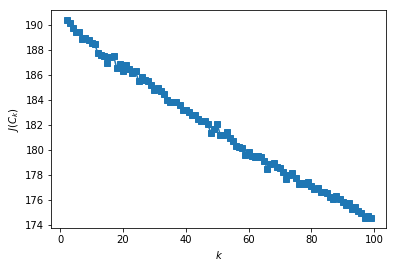

In [180]:
# подбор кластера
func = []
for k in range(2, 100):
    kmeans = KMeans(n_clusters=k, random_state=1).fit(matrix.toarray())
    func.append(np.sqrt(kmeans.inertia_))
    print (k)

import matplotlib.pyplot as plt
plt.plot(range(2, 100), func, marker='s');
plt.xlabel('$k$')
plt.ylabel('$J(C_k)$');


In [178]:
#словарь подбираем
n_clusters=100
vectorizer = TfidfVectorizer(min_df=100, max_df=600)
matrix = vectorizer.fit_transform(questions_norm[:])
print ('Dictionary size: ',matrix.shape[1])

k_model = KMeans(n_clusters=n_clusters, random_state=1)
cluster_target = k_model.fit_predict(matrix.toarray())
print ('learning models DONE')

#размеры кластеров
for claster_num in range(n_clusters):
    print ("Размер кластера "+ str(claster_num) + ': ' + str(np.array(np.where(cluster_target == claster_num)).size))

print ("Топы слов для кластеров:")    
for claster_num in range(n_clusters):
    print ("Кластер "+ str(claster_num))
    top_words_in_cluster(matrix.toarray()[np.where(cluster_target==claster_num)], vectorizer.get_feature_names())

Dictionary size:  816
learning models DONE
Размер кластера 0: 164
Размер кластера 1: 217
Размер кластера 2: 292
Размер кластера 3: 201
Размер кластера 4: 1
Размер кластера 5: 21111
Размер кластера 6: 140
Размер кластера 7: 218
Размер кластера 8: 148
Размер кластера 9: 96
Размер кластера 10: 231
Размер кластера 11: 162
Размер кластера 12: 156
Размер кластера 13: 92
Размер кластера 14: 118
Размер кластера 15: 184
Размер кластера 16: 109
Размер кластера 17: 235
Размер кластера 18: 128
Размер кластера 19: 165
Размер кластера 20: 274
Размер кластера 21: 390
Размер кластера 22: 176
Размер кластера 23: 147
Размер кластера 24: 277
Размер кластера 25: 154
Размер кластера 26: 254
Размер кластера 27: 277
Размер кластера 28: 93
Размер кластера 29: 331
Размер кластера 30: 220
Размер кластера 31: 187
Размер кластера 32: 272
Размер кластера 33: 234
Размер кластера 34: 137
Размер кластера 35: 224
Размер кластера 36: 205
Размер кластера 37: 220
Размер кластера 38: 295
Размер кластера 39: 297
Размер кла

['полн' 'тариф' 'посмотрет' 'список' 'погашен' 'зачислен' 'истор'
 'последн' 'отчет' 'мес' 'показыва' 'размер' 'отобража' 'ран' 'заход'
 'точн' 'всегд' 'сб' 'приня' 'измен' 'невозможн' 'страховк' 'захож' 'нача'
 'смен' 'сбо' 'получател' 'нашел' 'исправ' 'повтор']
Кластер 24
['забра' 'заказыва' 'готов' 'перевыпущен' 'прийт' 'приеха' 'выдач'
 'оформля' 'подлеж' 'придт' 'заканчива' 'законч' 'автоматическ' 'пок'
 'придет' 'успел' 'пода' 'две' 'июн' 'окончан' 'знач' 'три' 'нахож'
 'статус' 'отда' 'рук' 'срочн' 'заб' 'жив' 'раньш']
Кластер 25
['бик' 'ин' 'получател' 'расчетн' 'нуж' 'нашел' 'ул' 'найт' 'организац'
 'могл' 'неверн' 'прос' 'paypal' 'указыва' 'нибуд' 'полн' 'лицев' 'суток'
 'ввож' 'счёта' 'област' 'наход' 'пробл' 'заплат' 'жив' 'здраств' 'придут'
 'остальн' 'напиш' 'адрес']
Кластер 26
['моментум' 'бесплатн' 'электрон' 'платн' 'выдач' 'меня' 'мастеркард'
 'оформля' 'заканчива' 'здраств' 'социальн' 'годов' 'объясн' 'перевыпуст'
 'буд' 'истек' 'продл' 'перевыпуска' 'расплат' 'име' 

['правильн' 'верн' 'введ' 'получател' 'ввож' 'поня' 'цифр' 'ввод' 'всё'
 'ввел' 'провер' 'нормальн' 'организац' 'адрес' 'ввест' 'указыва' 'пиш'
 'называ' 'долж' 'заполн' 'неправильн' 'придут' 'обратн' 'лин' 'чём'
 'слов' 'московск' 'границ' 'выбра' 'такж']
Кластер 54
['войт' 'вход' 'помог' 'одноразов' 'логин' 'недоступн' 'sms' 'попытк' 'сб'
 'ввож' 'зайт' 'подтверд' 'происход' 'час' 'давн' 'смен' 'помощ' 'во'
 'сбербанконлайн' 'зарегистрирова' 'сист' 'сим' 'российск' 'компьютер'
 'повтор' 'нахож' 'снов' 'прос' 'под' 'доступн']
Кластер 55
['моб' 'пополн' 'смен' 'разблокирова' 'тел' 'помощ' 'пополнен' 'подключен'
 'подключа' 'годов' 'идт' 'термина' 'дом' 'пакет' 'час' 'двух' 'ушл'
 'самостоятельн' 'выход' 'нахож' 'доступ' 'случайн' 'видим' 'люд' 'курс'
 'здраств' 'измен' 'некотор' 'пишут' 'перевыпуст']
Кластер 56
['сервис' 'копилк' 'помощ' 'платн' 'вход' 'мтс' 'минут' 'расход'
 'отобража' 'выполн' 'час' 'либ' 'дозвон' 'поддержк' 'посмотрет'
 'заработа' 'paypal' 'возврат' 'них' 'почт' 'вс

['бонус' 'начисля' 'потрат' 'программ' 'воспользова' 'мтс' 'начисл'
 'принима' 'покупок' 'акц' 'про' 'правд' 'использова' 'компан' 'двух'
 'жкх' 'регистрац' 'посмотрет' 'куп' 'детск' 'восстанов' 'явля' 'трат'
 'начислен' 'открыва' 'возвраща' 'две' 'списыва' 'расплат' 'автоплатеж']
Кластер 84
['пакет' 'полн' 'тариф' 'золот' 'бесплатн' 'подключен' 'списыва'
 'подключа' 'вход' 'обязательн' 'уведомлен' 'измен' 'например' 'цен'
 'оформля' 'одноразов' 'нуж' 'пользован' 'виж' 'classic' 'лиц' 'равн'
 'выбра' 'предложен' 'правильн' 'оповещен' 'рассматрива' 'обычн' 'идт'
 'пополнен']
Кластер 85
['овердрафт' 'списыва' 'подключа' 'объясн' 'знач' 'минус' 'техническ'
 'произошл' 'сбо' 'поня' 'лимит' 'маленьк' 'classic' 'основан' 'вечер'
 'просроч' 'стал' 'правильн' 'остав' 'возвраща' 'польз' 'никогд' 'слов'
 'понима' 'постоя' 'чег' 'вернул' 'центр' 'снов' 'нем']
Кластер 86
['групп' 'личк' 'страниц' 'представля' 'официальн' 'будьт' 'сообща'
 'отвеча' 'прос' 'обращен' 'зада' 'контакт' 'люд' 'якоб' 'вн

In [191]:
from scipy.signal import argrelextrema
a=np.array([0,1,2,1,2,1,4,0])

np.array(argrelextrema(a, np.greater))[0].size

3